In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex as re

In [2]:
df = pd.read_csv('data/all_phages_abundance.csv', sep=',')

In [3]:
df.head()

Sample  day  treatment  \
0  STM_0716_E_M_E002  0.0  unamended   
1  STM_0716_E_M_E002  0.0  unamended   
2  STM_0716_E_M_E002  0.0  unamended   
3  STM_0716_E_M_E002  0.0  unamended   
4  STM_0716_E_M_E002  0.0  unamended   

                                      Contig  abundance         Host genome  \
0  20100900_E1D_10_c_000000000306||0_partial   0.885349  GB_GCA_003131315.1   
1  20100900_E1D_10_c_000000000306||0_partial   0.885349        3300027825_9   
2  20100900_E1D_10_c_000000000306||0_partial   0.885349  GB_GCA_003132325.1   
3  20100900_E1D_10_c_000000000306||0_partial   0.885349  GB_GCA_003168235.1   
4  20100900_E1D_10_c_000000000306||0_partial   0.885349  GB_GCA_003139995.1   

                                       Host taxonomy Main method  \
0  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...       blast   
1  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...       blast   
2  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...       blast   
3  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...       blast   
4  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...       blast   

   Confidence score Additional methods            K                   P  \
0              92.2     iPHoP-RF;66.00  d__Bacteria  p__Acidobacteriota   
1              91.7     iPHoP-RF;59.20  d__Bacteria  p__Acidobacteriota   
2              90.9     iPHoP-RF;53.00  d__Bacteria  p__Acidobacteriota   
3              90.8     iPHoP-RF;68.90  d__Bacteria  p__Acidobacteriota   
4              90.5     iPHoP-RF;50.70  d__Bacteria  p__Acidobacteriota   

                   C                    O                   F           G  \
0  c__Acidobacteriae  o__Acidobacteriales  f__Koribacteraceae  g__Bog-209   
1  c__Acidobacteriae  o__Acidobacteriales  f__Koribacteraceae  g__Bog-209   
2  c__Acidobacteriae  o__Acidobacteriales  f__Koribacteraceae  g__Bog-209   
3  c__Acidobacteriae  o__Acidobacteriales  f__Koribacteraceae  g__Bog-209   
4  c__Acidobacteriae  o__Acidobacteriales  f__Koribacteraceae  g__Bog-209   

                        S  prophage  
0  s__Bog-209 sp003131315  prophage  
1                     s__  prophage  
2  s__Bog-209 sp003132325  prophage  
3  s__Bog-209 sp003168235  prophage  
4  s__Bog-209 sp003139995  prophage

# How many were detected, and how many of those detected were in the original stordalen dataset?

In [5]:
# load in reps from stordalen_overlap.py. This is a list of all representatives that had a stordalen sequence clustered
# at 95% ANI cutoff with it.
with open('data/stordalen_overlap_cluster_headers_10kb.tsv') as f:
    stor_lst = [i.strip('\n') for i in f.readlines()]
stor_lst[:10]

['20160700_E14.VIRSorter_NODE_1_length_351989_cov_12_429615_gene_124_gene_477-68188-352037-cat_5',
 '20120700_P3D.VIRSorter_NODE_161_length_217151_cov_11_826464-circular-cat_2',
 '20130700_S2X.VIRSorter_NODE_3_length_197518_cov_59_067982-cat_2',
 '20140700_S11.VIRSorter_NODE_5_length_190782_cov_9_251422-cat_2',
 '20110700_S1S.VIRSorter_NODE_1_length_186748_cov_10_597912-cat_2',
 '20120800_E2X.VIRSorter_NODE_52_length_167441_cov_24_979359-circular-cat_2',
 '20160700_S15.VIRSorter_NODE_2_length_166797_cov_9_507389-cat_2',
 '20120800_E1X.VIRSorter_NODE_27_length_162874_cov_6_971084-cat_2',
 '20120700_E2X.VIRSorter_NODE_18_length_209734_cov_38_895230-circular_gene_1_gene_212-0-155642-cat_5',
 '20120700_P3D.VIRSorter_NODE_109_length_252830_cov_8_771928_gene_1_gene_156-0-154249-cat_5']

In [9]:
# which contigs had zero abundance?
total_abundance = df.groupby('Contig').agg({'abundance': np.sum}).reset_index()

In [10]:
total_abundance.head()

Contig   abundance
0  20100900_E1D.VIRSorter_NODE_1646_length_12567_...  395.041600
1  20100900_E1D.VIRSorter_NODE_1718_length_12231_...  151.517568
2  20100900_E1D.VIRSorter_NODE_789_length_20219_c...  340.803340
3          20100900_E1D_10_c_000000000306||0_partial  254.795619
4  20100900_E1S.VIRSorter_NODE_30_length_27093_co...   20.659253

In [13]:
len(total_abundance), len(total_abundance.loc[total_abundance.abundance != 0])

(2409, 2409)

In [18]:
len(total_abundance.loc[total_abundance.Contig.isin(stor_lst)])

848

In [16]:
2409-848

1561

In [50]:
# how many with no hosts?
df.loc[~df['Host taxonomy'].isnull()][['K', 'P', 'C', 'O', 'F', 'G', 'S']].nunique()

K       2
P      26
C      44
O      73
F      97
G     199
S    1234
dtype: int64

In [5]:
df[['Contig', 'Host taxonomy', 'Main method']].drop_duplicates()['Main method'].value_counts()

blast       3641
iPHoP-RF    1849
CRISPR         6
Name: Main method, dtype: int64

In [6]:
df['Contig_HostGenus'] = df.Contig + '\n' + df.G

In [7]:
df.abundance.loc[df['abundance'] != 0].min()

0.319272792330304

In [8]:
# how many unique hosts?
df.G.nunique()

199

# Plot hosts and number of viruses

In [9]:
import plotly.graph_objects as go
import networkx as nx

In [10]:
phage_host_pairs = df[['Contig', 'G']]
phage_host_pairs.columns = ['source', 'target']

In [33]:
phage_host_pairs.drop_duplicates().target.value_counts()

d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__                                               98
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium beijerinckii                       70
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium puniceum                           68
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium beijerinckii_D                     59
d__Bacteria;p__Firmicutes_A;c__Clostridia;o__Clostridiales;f__Clostridiaceae;g__Clostridium;s__Clostridium neonatale                          53
                                                                                                                                              ..
d__Bacteria;p__Actinobacteriota;c__Actinomycetia;o__Mycobacteriales;f__Mycobacteriaceae;g__Mycobacterium;s__Mycobacterium dioxanot

In [12]:
G = nx.from_pandas_edgelist(phage_host_pairs)

In [13]:
# https://stackoverflow.com/questions/27030473/how-to-set-colors-for-nodes-in-networkx
color_map = []
for node in G:
    if node in list(phage_host_pairs['source']):
        color_map.append("#F2A039") # orange
    else:
        color_map.append("#3A8AD8") # blue

In [14]:
# write for cytoscape
nx.write_graphml(G, 'data/all_phageHostPairs.xml')

The rest of processing was done in cytoscape

# Plot for species-level to compare

In [15]:
phage_host_pairs = df[['Contig', 'Host taxonomy']]
phage_host_pairs.columns = ['source', 'target']

In [16]:
phage_host_pairs

source  \
0       20100900_E1D.VIRSorter_NODE_1718_length_12231_...   
1       20100900_E1D.VIRSorter_NODE_1718_length_12231_...   
2       20100900_E1D.VIRSorter_NODE_1718_length_12231_...   
3       20100900_E1D.VIRSorter_NODE_1718_length_12231_...   
4       20100900_E1D.VIRSorter_NODE_1718_length_12231_...   
...                                                   ...   
232593        STM_0716_E_M_E069_megahit_k121_953506||full   
232594        STM_0716_E_M_E069_megahit_k121_953506||full   
232595        STM_0716_E_M_E069_megahit_k121_953506||full   
232596        STM_0716_E_M_E069_megahit_k121_953506||full   
232597        STM_0716_E_M_E069_megahit_k121_953506||full   

                                                   target  
0       d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...  
1       d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...  
2       d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...  
3       d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...  
4       d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...  
...                                                   ...  
232593                                                NaN  
232594                                                NaN  
232595                                                NaN  
232596                                                NaN  
232597                                                NaN  

[232598 rows x 2 columns]

In [17]:
phage_host_pairs = phage_host_pairs.drop_duplicates()

In [18]:
phage_host_pairs

source  \
0       20100900_E1D.VIRSorter_NODE_1718_length_12231_...   
38      20100900_E1D.VIRSorter_NODE_789_length_20219_c...   
76      20100900_E2D.VIRSorter_NODE_113_length_31894_c...   
77      20100900_E2D.VIRSorter_NODE_113_length_31894_c...   
78      20100900_E2D.VIRSorter_NODE_113_length_31894_c...   
...                                                   ...   
232297       STM_0716_E_M_E069_megahit_k121_86451||full_2   
232298       STM_0716_E_M_E069_megahit_k121_86451||full_2   
232484        STM_0716_E_M_E069_megahit_k121_922055||full   
232485        STM_0716_E_M_E069_megahit_k121_922055||full   
232560        STM_0716_E_M_E069_megahit_k121_953506||full   

                                                   target  
0       d__Bacteria;p__Chloroflexota;c__Dehalococcoidi...  
38                                                    NaN  
76      d__Archaea;p__Halobacteriota;c__Bog-38;o__Bog-...  
77      d__Archaea;p__Halobacteriota;c__Bog-38;o__Bog-...  
78      d__Archaea;p__Halobacteriota;c__Bog-38;o__Bog-...  
...                                                   ...  
232297  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  
232298  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  
232484  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  
232485  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...  
232560                                                NaN  

[5892 rows x 2 columns]

In [19]:
G = nx.from_pandas_edgelist(phage_host_pairs)

In [20]:
# https://stackoverflow.com/questions/27030473/how-to-set-colors-for-nodes-in-networkx
color_map = []
for node in G:
    if node in list(phage_host_pairs['source']):
        color_map.append("#F2A039") # orange
    else:
        color_map.append("#3A8AD8") # blue

In [21]:
# write for cytoscape
nx.write_graphml(G, 'data/all_phageHostPairsSpeciesLevel.xml')

# Find patterns in viral transcript dynamics

Cluster each Contig_HostGenus by the trend of day vs abundance. OK turns out this is not easy to do! I am struggling to find a way to do this easily.

# Calculate significant differences between treatment in respect to catechin

In [23]:
# List of timepoints
timepoints = [0, 7, 14, 21, 35]

# Treatment labels
catechin_label = 'catechin'
unamended_label = 'unamended'
ct_label = 'CT'

# Critical value for T-test
critical_value = 0.05

# Create an empty DataFrame to store significant results
significant_results = pd.DataFrame(columns=['Contig_HostGenus', 'Timepoint', 'T-Value', 'P-Value'])
count = 0
# Perform t-test for each virus at each timepoint
for contig in df['Contig_HostGenus'].unique():
    contig_df = df[df['Contig_HostGenus'] == contig]
    count += 1
    for timepoint in timepoints:
        subset_df = contig_df[contig_df['day'] == timepoint]
        
        # Perform independent t-test for catechin vs. unamended
        ttest_result_unamended = ttest_ind(subset_df[subset_df['treatment'] == catechin_label]['abundance'],
                                           subset_df[subset_df['treatment'] == unamended_label]['abundance'])
        
        # Perform independent t-test for catechin vs. CT
        ttest_result_ct = ttest_ind(subset_df[subset_df['treatment'] == catechin_label]['abundance'],
                                    subset_df[subset_df['treatment'] == ct_label]['abundance'])
        
        # Check if T-value is greater than the critical value
        if (abs(ttest_result_unamended.pvalue) < critical_value) and (abs(ttest_result_ct.pvalue) < critical_value):
            significant_results = significant_results.append({
                'Contig_HostGenus': contig,
                'Timepoint': timepoint,
                'T-Value': ttest_result_unamended.statistic,
                'P-Value': ttest_result_unamended.pvalue
            }, ignore_index=True)

# Filter significant results based on the critical value
filtered_results = significant_results[abs(significant_results['P-Value']) < critical_value]

In [24]:
filtered_results.Contig_HostGenus.nunique()

414

In [25]:
df.Contig_HostGenus.nunique(), significant_results.Contig_HostGenus.nunique()

(999, 414)

In [26]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return ""

In [27]:
significant_results['Significance'] = significant_results['P-Value'].apply(convert_pvalue_to_asterisks)

In [28]:
# Extract Contig_HostGenus, day, and P-Value from filtered_results
significant_contigs = filtered_results[['Contig_HostGenus', 'Timepoint', 'P-Value']]

# Create a new column in the original DataFrame to store significance level indicators
df['Significance'] = ""

# Map significance level indicators to the corresponding data points
for idx, row in significant_contigs.iterrows():
    contig = row['Contig_HostGenus']
    timepoint = row['Timepoint']
    p_value = row['P-Value']
    
    # Find the index in the original DataFrame for the specified contig and timepoint
    idx_to_update = df[(df['Contig_HostGenus'] == contig) & (df['day'] == timepoint)].index
    
    # Update the 'Significance' column with the corresponding significance level indicator
    df.loc[idx_to_update, 'Significance'] = convert_pvalue_to_asterisks(p_value)

In [29]:
df.columns

Index(['Sample', 'day', 'treatment', 'Contig', 'abundance', 'Host genome',
       'Host taxonomy', 'Main method', 'Confidence score',
       'Additional methods', 'K', 'P', 'C', 'O', 'F', 'G', 'S', 'prophage',
       'Contig_HostGenus', 'Significance'],
      dtype='object')

In [30]:
df.G.unique()

array(['g__Fen-1064', nan, 'g__Bog-38', 'g__FEN-1257', 'g__Fen-549',
       'g__UBA7542', 'g__UBA11358', 'g__Fen-330', 'g__Fen-178', 'g__LD21',
       'g__Solibacter', 'g__Bog-375', 'g__CAIRSA01', 'g__PALSA-129',
       'g__', 'g__Terracidiphilus', 'g__PALSA-243', 'g__Bog-209',
       'g__Fen-1137', 'g__Sulfopaludibacter', 'g__Fen-1364', 'g__BOG-224',
       'g__Methylobacter_A', 'g__UBA2258', 'g__Fen-1467', 'g__Smithella',
       'g__Aquabacterium', 'g__Mycobacterium', 'g__Methylocystis',
       'g__Cybelea', 'g__Stenotrophomonas_A', 'g__Rhodoblastus',
       'g__RAAP-2', 'g__CAIKOH01', 'g__21-14-all-47-17', 'g__Fen-1273',
       'g__Fen-999', 'g__FEN-921', 'g__PSRJ01', 'g__Delta-02',
       'g__Rhizomicrobium', 'g__CAIVVT01', 'g__PALSA-986', 'g__Fen-183',
       'g__FEN-335', 'g__Sulfotelmatobacter', 'g__Streptomyces',
       'g__Methylosinus', 'g__UBA8199', 'g__PALSA-1440', 'g__CAIQQM01',
       'g__CAIUPP01', 'g__UBA7541', 'g__Palsa-288', 'g__UBA4719',
       'g__Cryosericum', 'g__

# Let's start by looking at hosts that had few overall viruses

In [333]:
# Plot using Seaborn with col parameter
def plot_vir_abundance(host, wrap=4):
    
    treatment_colors = {'catechin': '#fa8100', 'CT': '#1a7ab9', 'unamended': '#26a300'}
    
    filtered_df = df.loc[df['G'] == host]
    
    g = sns.FacetGrid(filtered_df,
                      col='Contig_HostGenus',
                      hue='treatment',
                      col_wrap=wrap,
                      height=4,
                      sharey=False,
                      palette=treatment_colors
                     )
    g.map(sns.scatterplot, 'day', 'abundance', markers='o')

    # Add a line through the average of the points
    g.map(sns.lineplot, 'day', 'abundance', estimator='mean', linestyle='-')

    # Add significance annotations
    for ax in g.axes.flatten():
        contig_host_genus = ax.get_title().split('Contig_HostGenus = ')[1]
        
        for i, point in filtered_df[filtered_df['Contig_HostGenus'] == contig_host_genus].iterrows():
            if (point['Significance'] != '') & (point['treatment'] == 'catechin'):
                ax.text(point['day'], point['abundance'], point['Significance'], ha='center', va='bottom', color='red')

        # Add prophage information        
        prophage_info = str(filtered_df[filtered_df['Contig_HostGenus'] == contig_host_genus]['prophage'].iloc[0])
        
        # Modify the title to include the "prophage" information
        if prophage_info == 'prophage':
            # ax.set_title(f'{contig_host_genus} \n {prophage_info}')
            # for presentation
            ax.set_title(f'{prophage_info}')
        else:
            ax.set_title('')
                
    # Adjust legend position
    # g.add_legend(loc='upper right')
    g.fig.suptitle(host)
    plt.show()

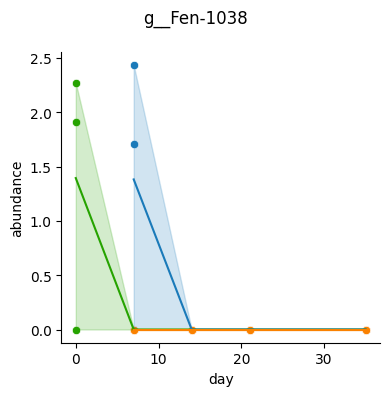

In [334]:
# Fen-1038
plot_vir_abundance('g__Fen-1038', 1)

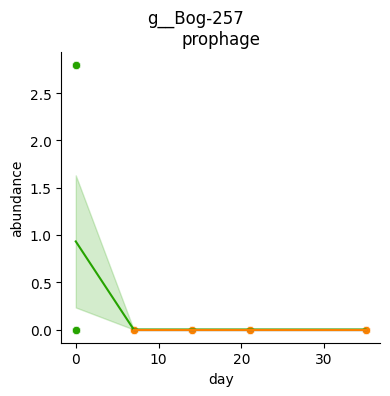

In [335]:
# Bog-257
plot_vir_abundance('g__Bog-257', 1)

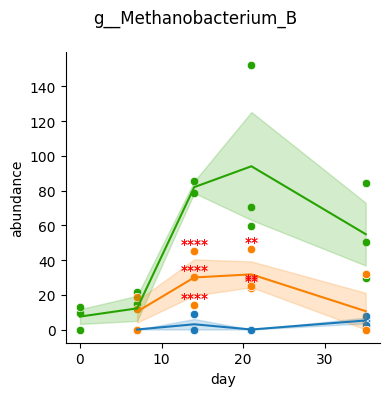

In [336]:
# Methanobacterium_B
plot_vir_abundance('g__Methanobacterium_B', 1)

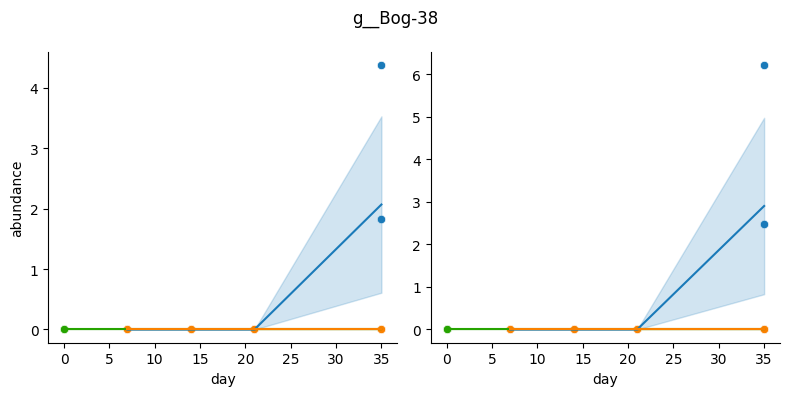

In [337]:
# Bog-38
plot_vir_abundance('g__Bog-38', 2)

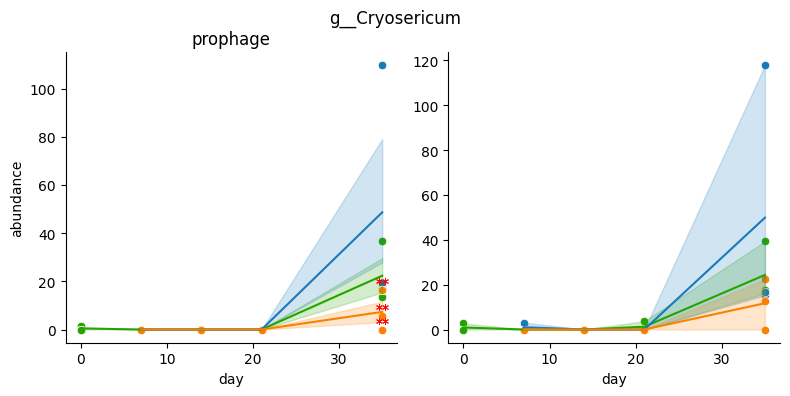

In [338]:
# Cryosericum
plot_vir_abundance('g__Cryosericum', 2)

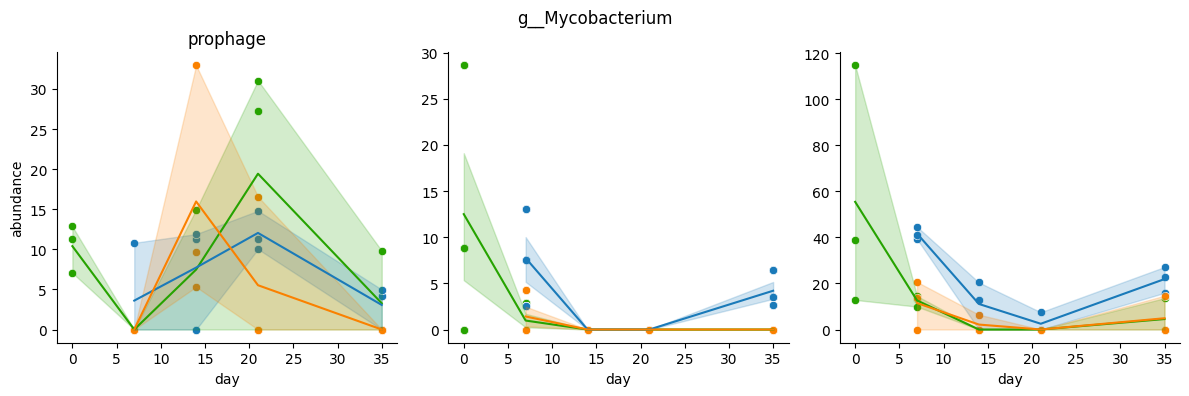

In [339]:
# Mycobacterium
plot_vir_abundance('g__Mycobacterium', 3)

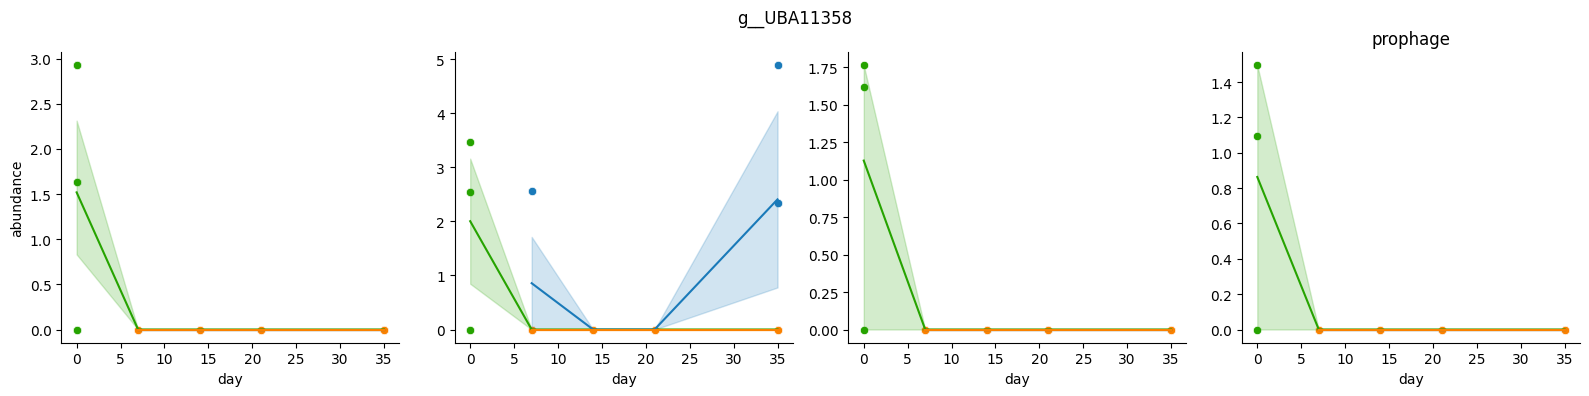

In [340]:
# UBA11358
plot_vir_abundance('g__UBA11358', 4)

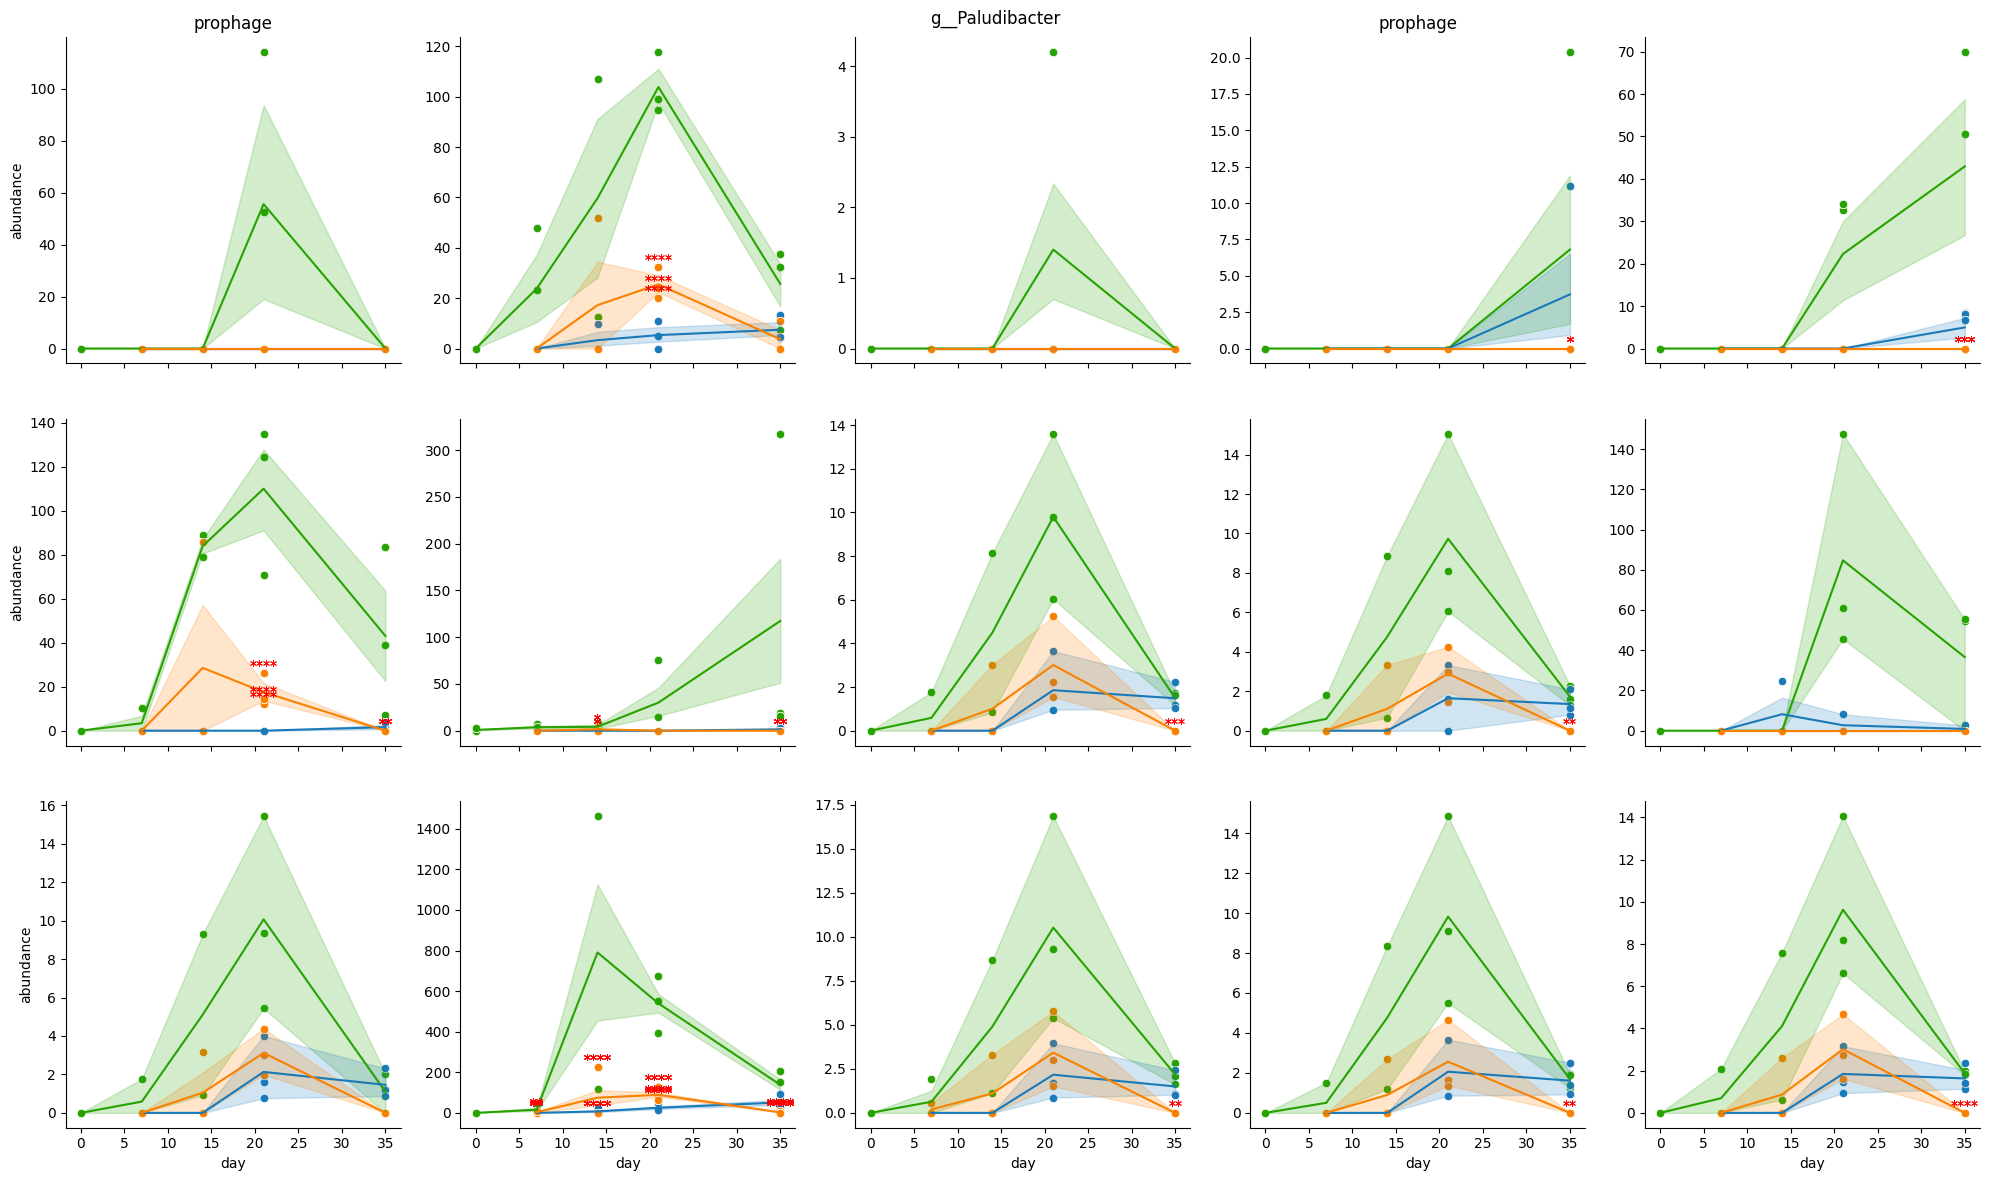

In [341]:
# Paludibacter
plot_vir_abundance('g__Paludibacter', wrap=5)

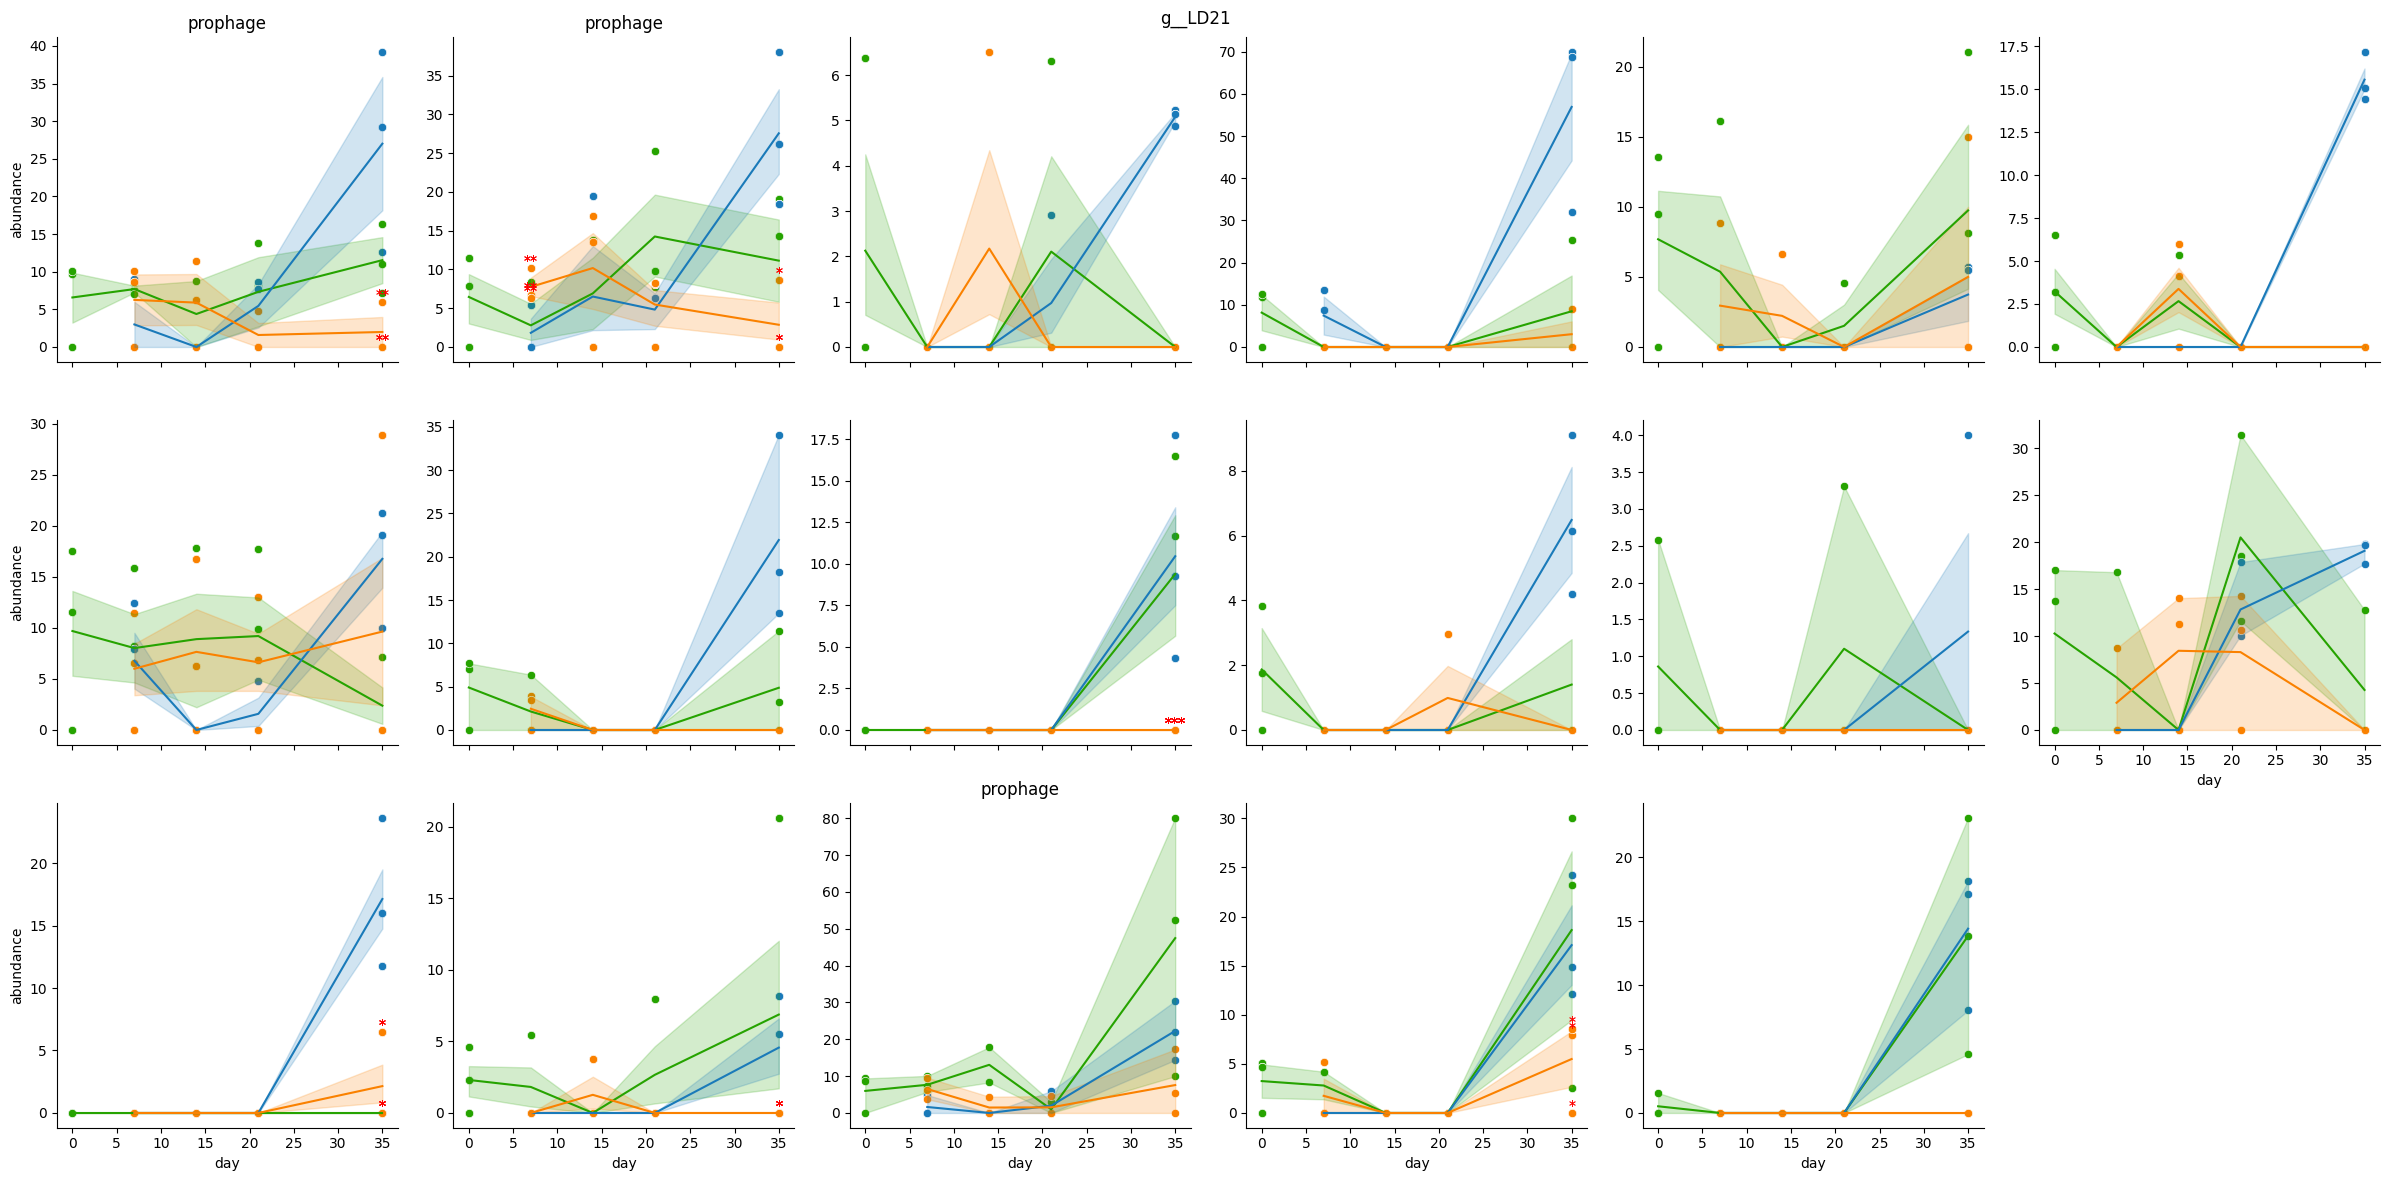

In [342]:
# LD21
plot_vir_abundance('g__LD21', 6)

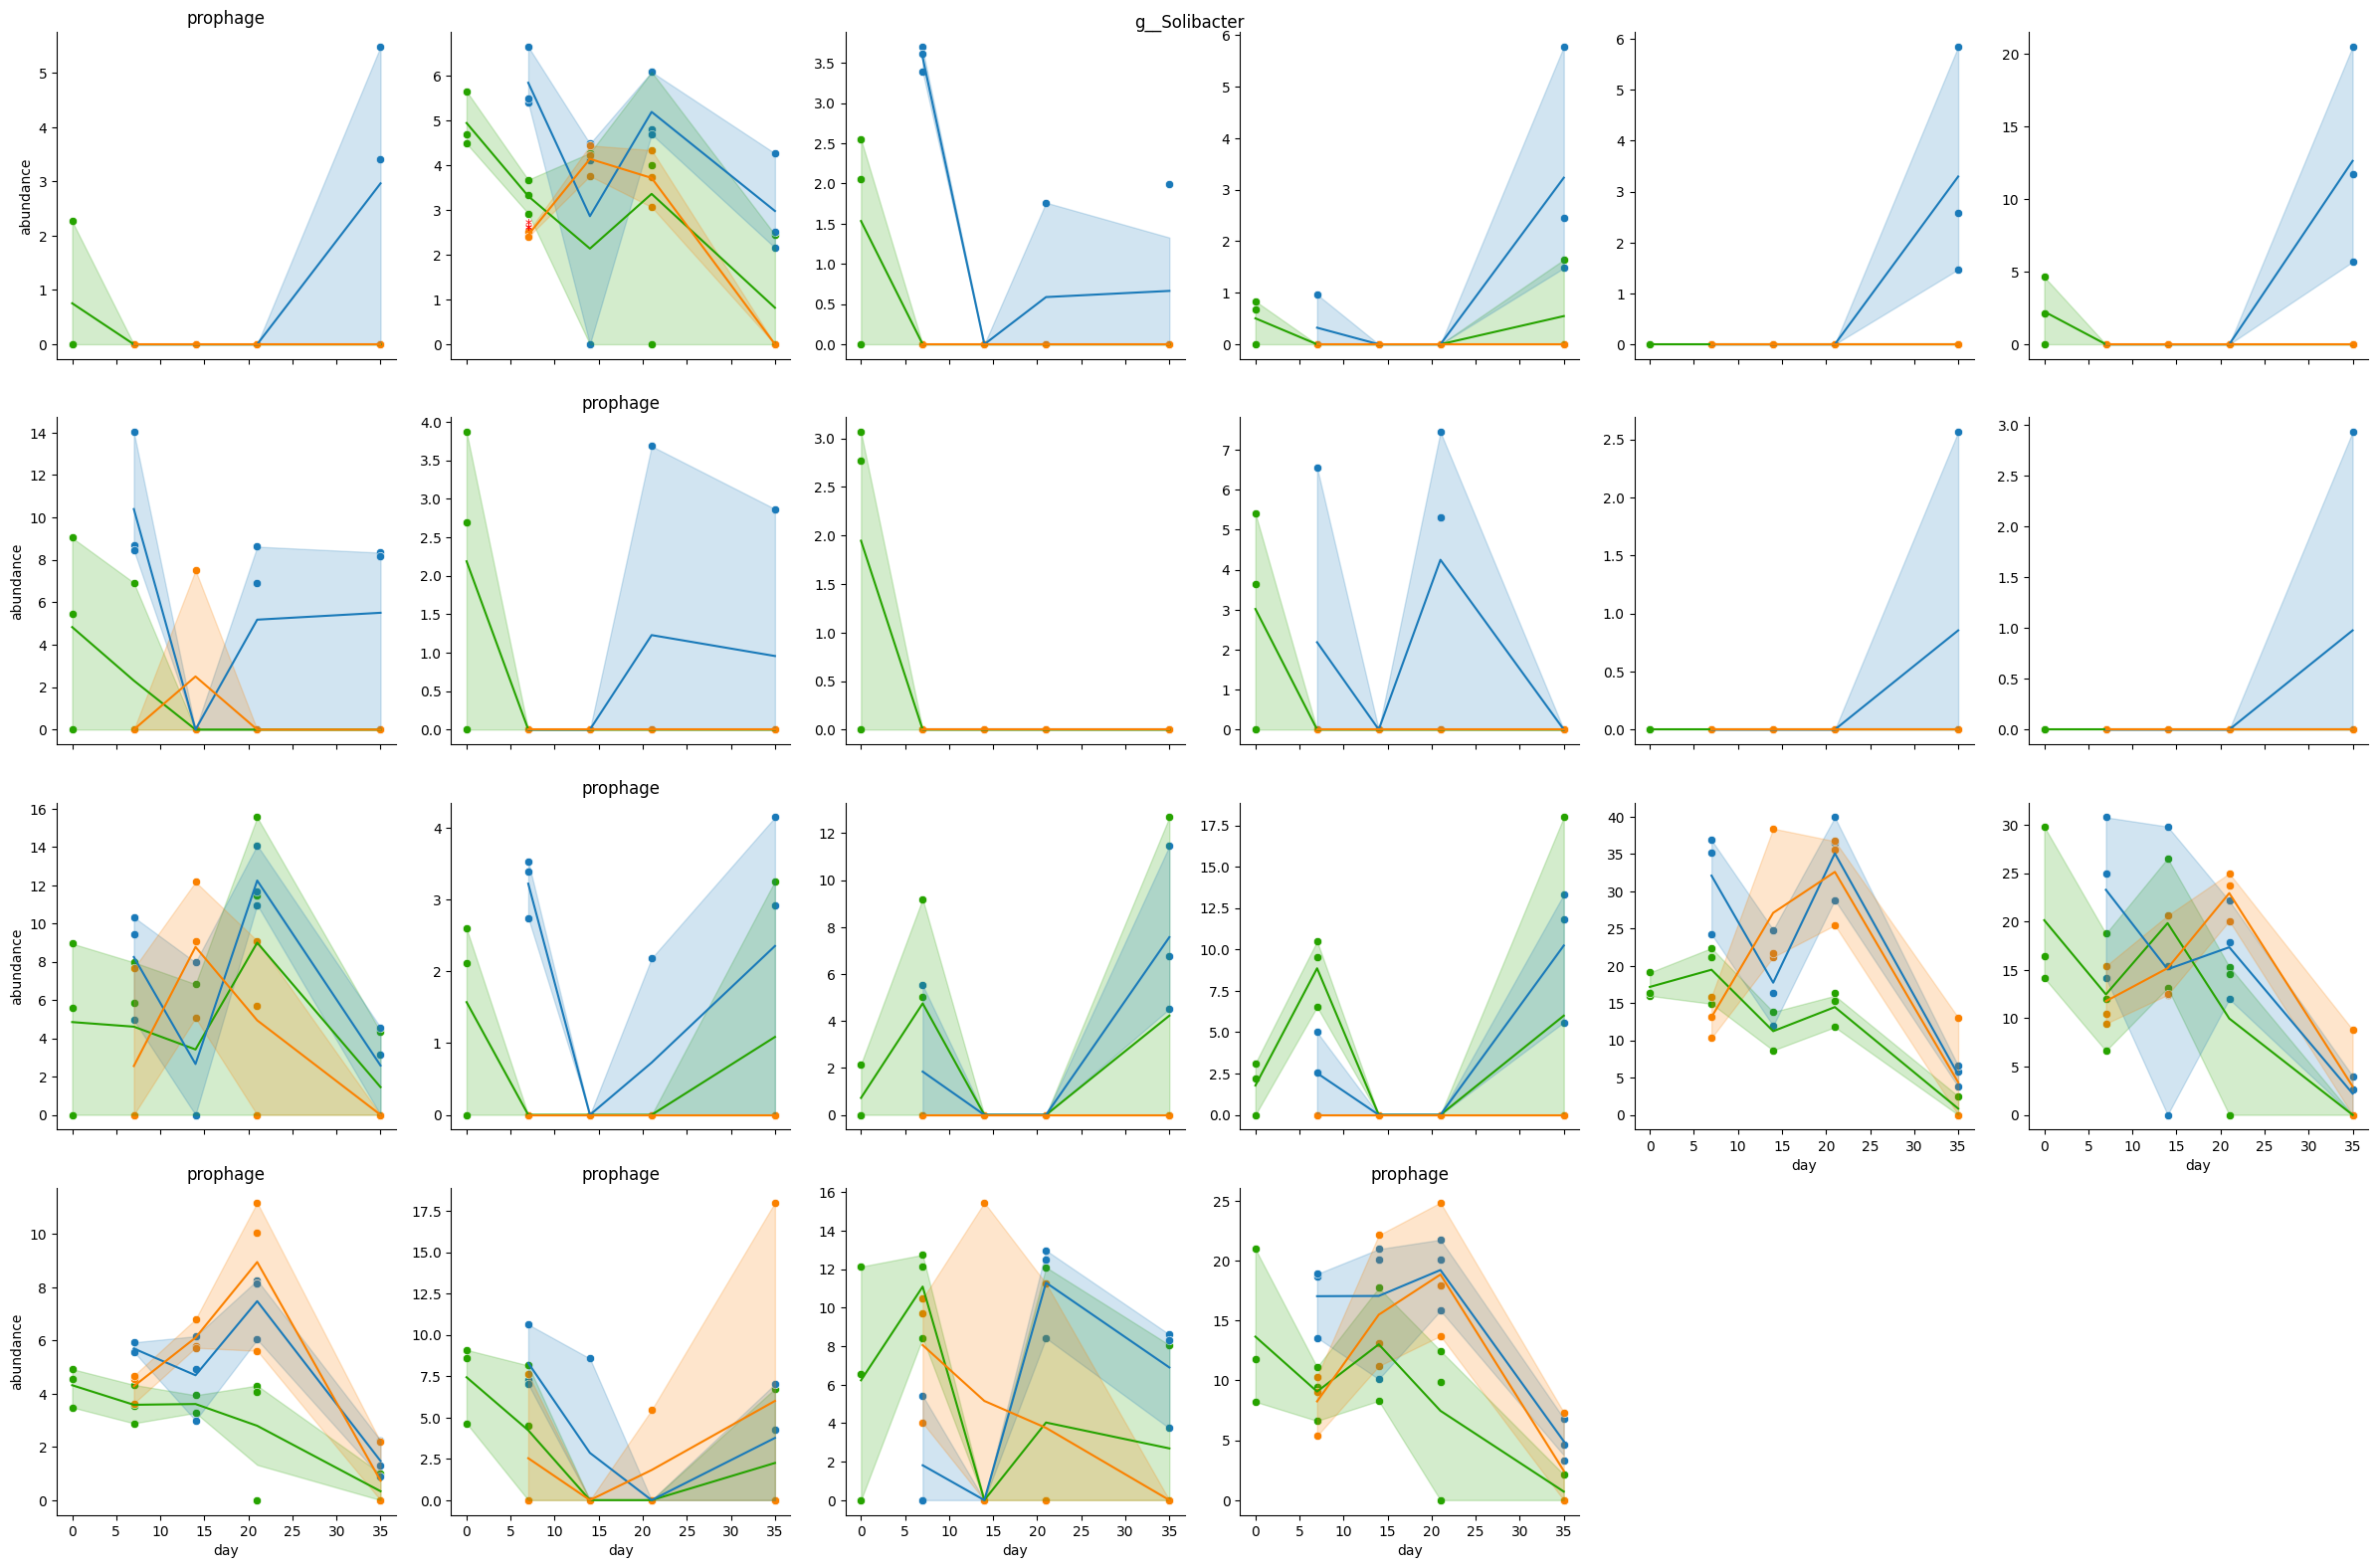

In [343]:
# Solibacter
plot_vir_abundance('g__Solibacter', 6)

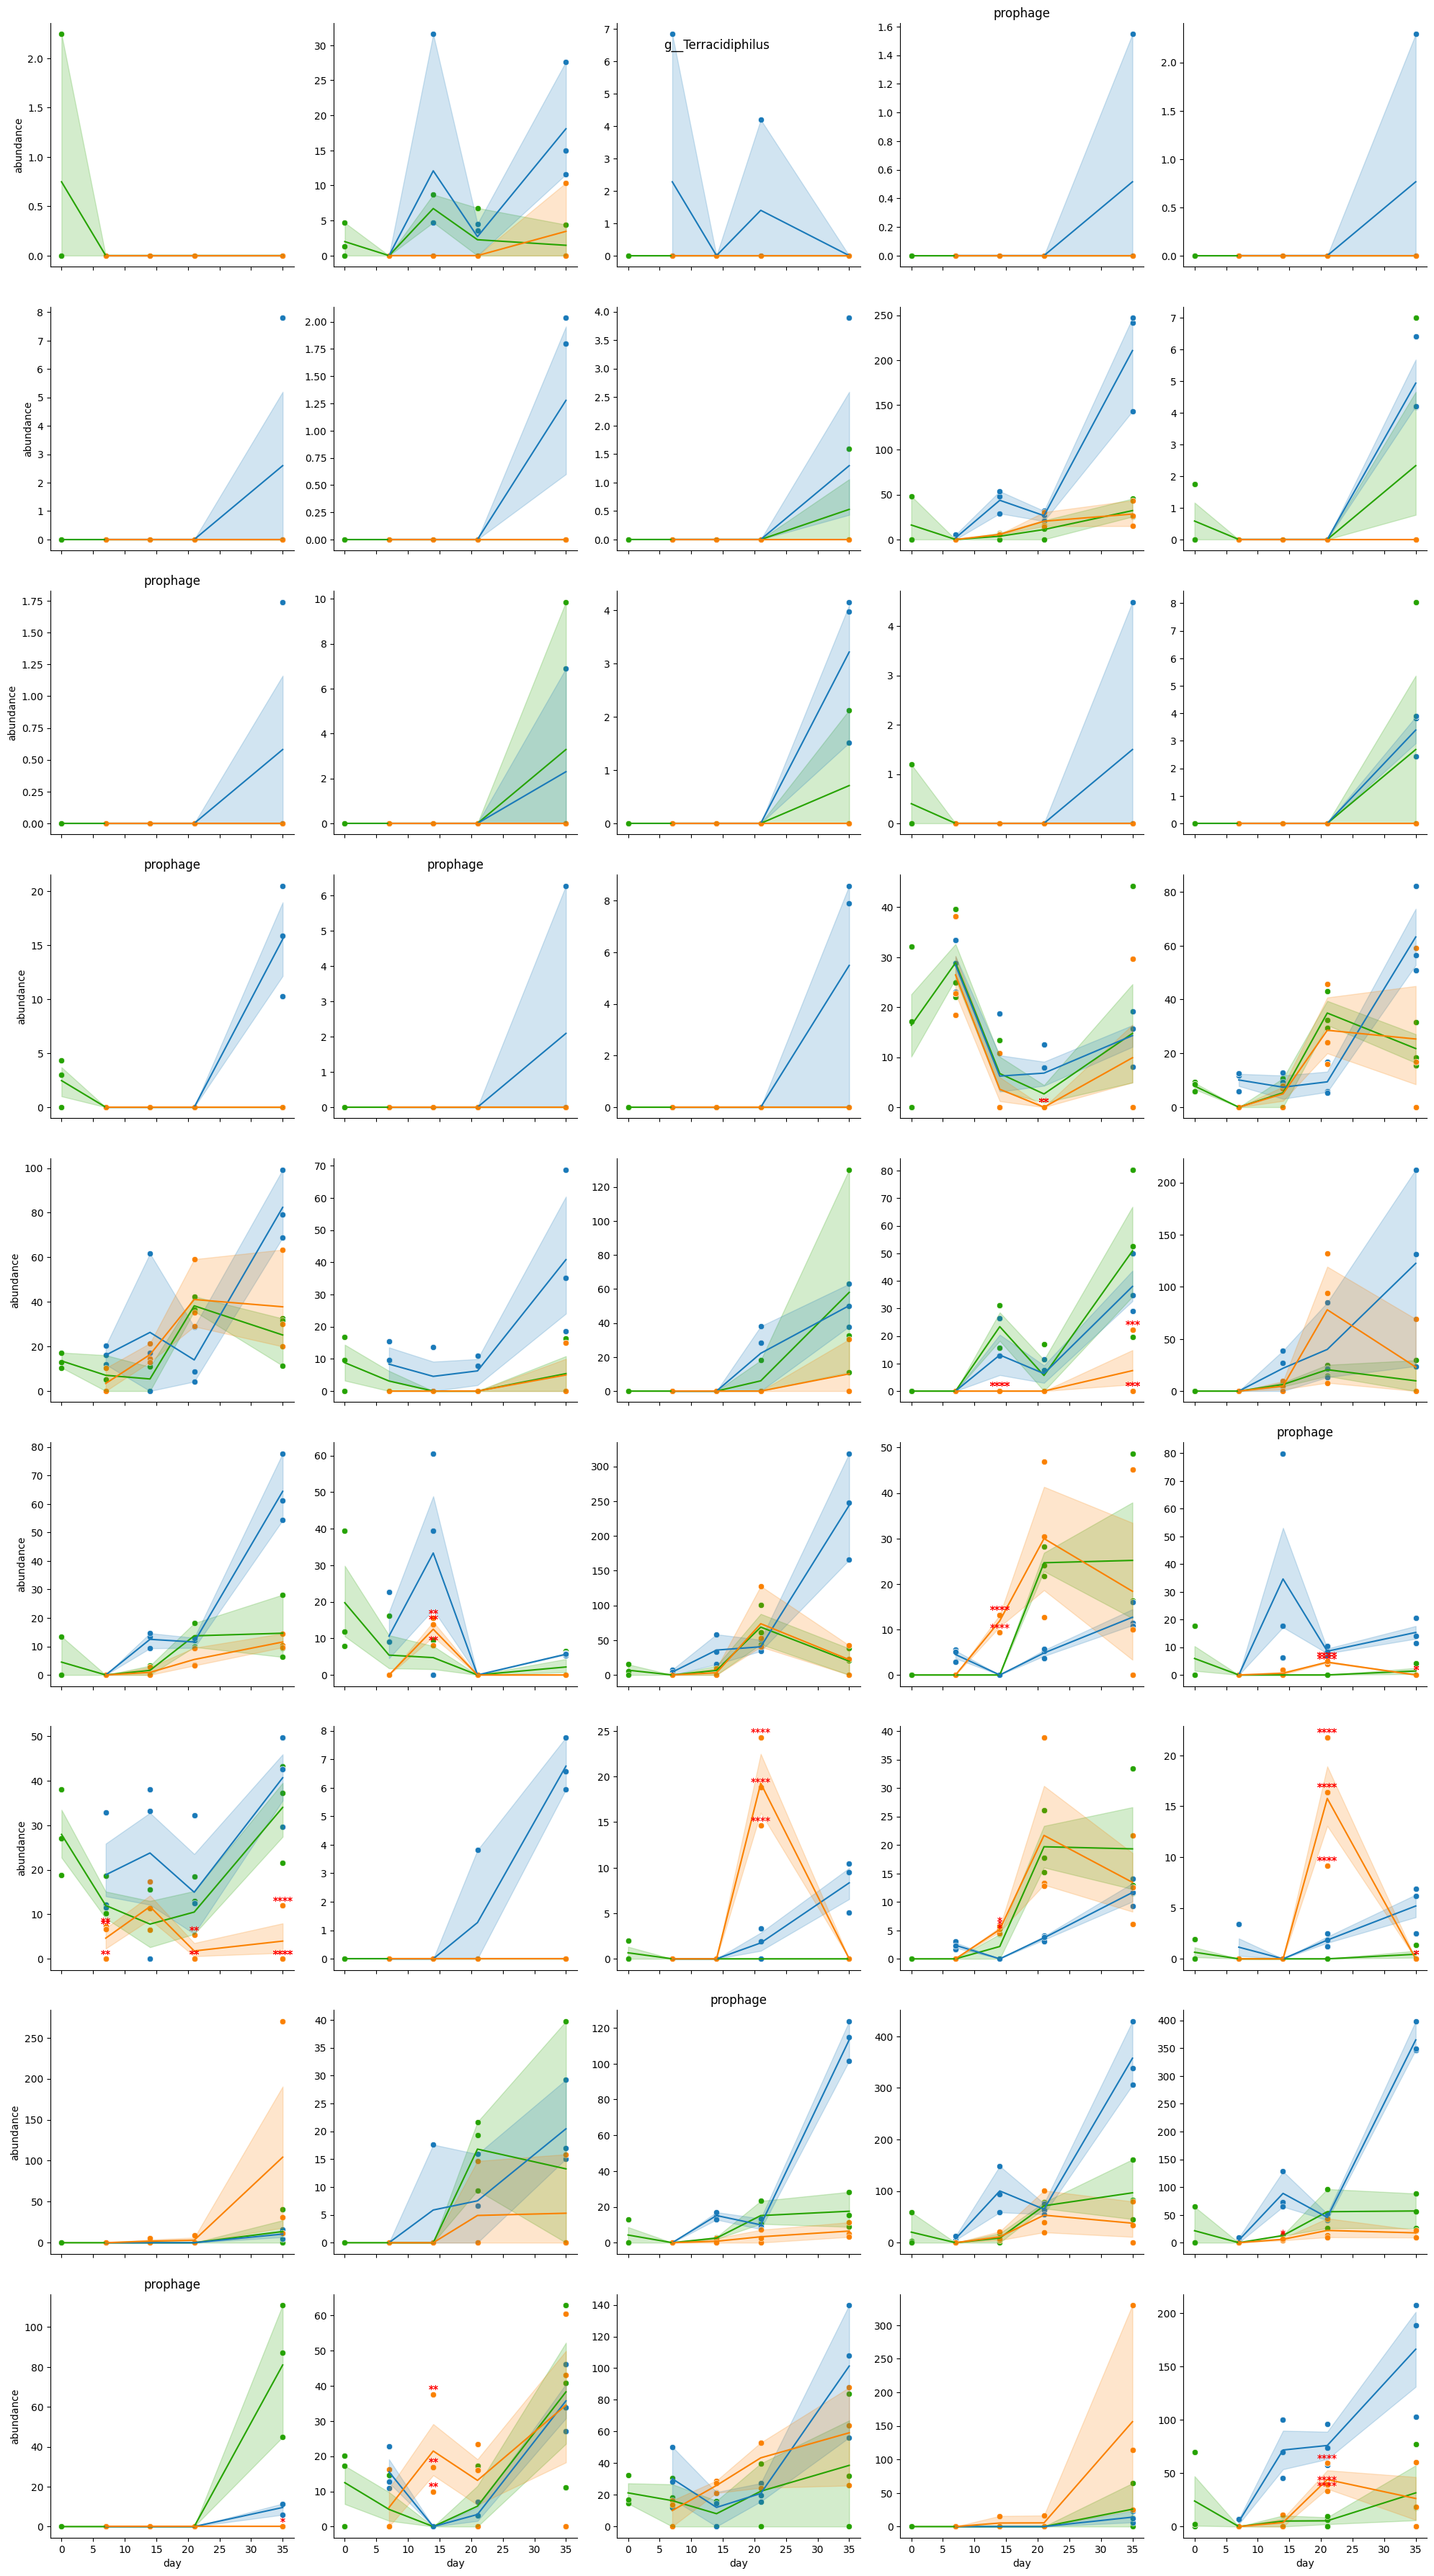

In [344]:
plot_vir_abundance('g__Terracidiphilus', 5)

# Only prophages

In [202]:
prophages = df.loc[df['prophage'] == 'prophage']

In [203]:
prophages

Sample  day  treatment  \
76    STM_0716_E_M_E002  0.0  unamended   
77    STM_0716_E_M_E002  0.0  unamended   
78    STM_0716_E_M_E003  0.0  unamended   
79    STM_0716_E_M_E003  0.0  unamended   
80    STM_0716_E_M_E004  0.0  unamended   
...                 ...  ...        ...   
3225  STM_0716_E_M_E126  7.0         CT   
3226  STM_0716_E_M_E127  7.0         CT   
3227  STM_0716_E_M_E129  7.0   catechin   
3228  STM_0716_E_M_E130  7.0   catechin   
3229  STM_0716_E_M_E131  7.0   catechin   

                                                 Contig  abundance  \
76                  20110700_E2S_1_c_000000000035||full   9.703245   
77                  20110700_E2S_1_c_000000000035||full   9.703245   
78                  20110700_E2S_1_c_000000000035||full   0.000000   
79                  20110700_E2S_1_c_000000000035||full   0.000000   
80                  20110700_E2S_1_c_000000000035||full  10.033062   
...                                                 ...        ...   
3225  PMTR01_ENA|PMTR01000131|PMTR01000131.1||0_partial   3.391032   
3226  PMTR01_ENA|PMTR01000131|PMTR01000131.1||0_partial   2.747463   
3227  PMTR01_ENA|PMTR01000131|PMTR01000131.1||0_partial   0.000000   
3228  PMTR01_ENA|PMTR01000131|PMTR01000131.1||0_partial   0.000000   
3229  PMTR01_ENA|PMTR01000131|PMTR01000131.1||0_partial   0.000000   

       Host genome                                      Host taxonomy  \
76    3300025692_6  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   
77    3300025692_5  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   
78    3300025692_6  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   
79    3300025692_5  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   
80    3300025692_6  d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...   
...            ...                                                ...   
3225  3300025481_3  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...   
3226  3300025481_3  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...   
3227  3300025481_3  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...   
3228  3300025481_3  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...   
3229  3300025481_3  d__Bacteria;p__Acidobacteriota;c__Acidobacteri...   

     Main method  Confidence score Additional methods            K  \
76         blast              91.8     iPHoP-RF;90.50  d__Bacteria   
77         blast              91.1     iPHoP-RF;80.60  d__Bacteria   
78         blast              91.8     iPHoP-RF;90.50  d__Bacteria   
79         blast              91.1     iPHoP-RF;80.60  d__Bacteria   
80         blast              91.8     iPHoP-RF;90.50  d__Bacteria   
...          ...               ...                ...          ...   
3225       blast              90.2     iPHoP-RF;68.40  d__Bacteria   
3226       blast              90.2     iPHoP-RF;68.40  d__Bacteria   
3227       blast              90.2     iPHoP-RF;68.40  d__Bacteria   
3228       blast              90.2     iPHoP-RF;68.40  d__Bacteria   
3229       blast              90.2     iPHoP-RF;68.40  d__Bacteria   

                       P                  C                  O  \
76       p__Bacteroidota     c__Bacteroidia   o__Bacteroidales   
77       p__Bacteroidota     c__Bacteroidia   o__Bacteroidales   
78       p__Bacteroidota     c__Bacteroidia   o__Bacteroidales   
79       p__Bacteroidota     c__Bacteroidia   o__Bacteroidales   
80       p__Bacteroidota     c__Bacteroidia   o__Bacteroidales   
...                  ...                ...                ...   
3225  p__Acidobacteriota  c__Acidobacteriae  o__Bryobacterales   
3226  p__Acidobacteriota  c__Acidobacteriae  o__Bryobacterales   
3227  p__Acidobacteriota  c__Acidobacteriae  o__Bryobacterales   
3228  p__Acidobacteriota  c__Acidobacteriae  o__Bryobacterales   
3229  p__Acidobacteriota  c__Acidobacteriae  o__Bryobacterales   

                       F              G    S  prophage  \
76          f__VadinHA17        g__LD21  s__  prophage   
77          f__VadinHA17        

In [ ]:
plot_vir_abundance()

# Terracidiphilus is particularly interesting... Let's try and plot this one alone

Only significant

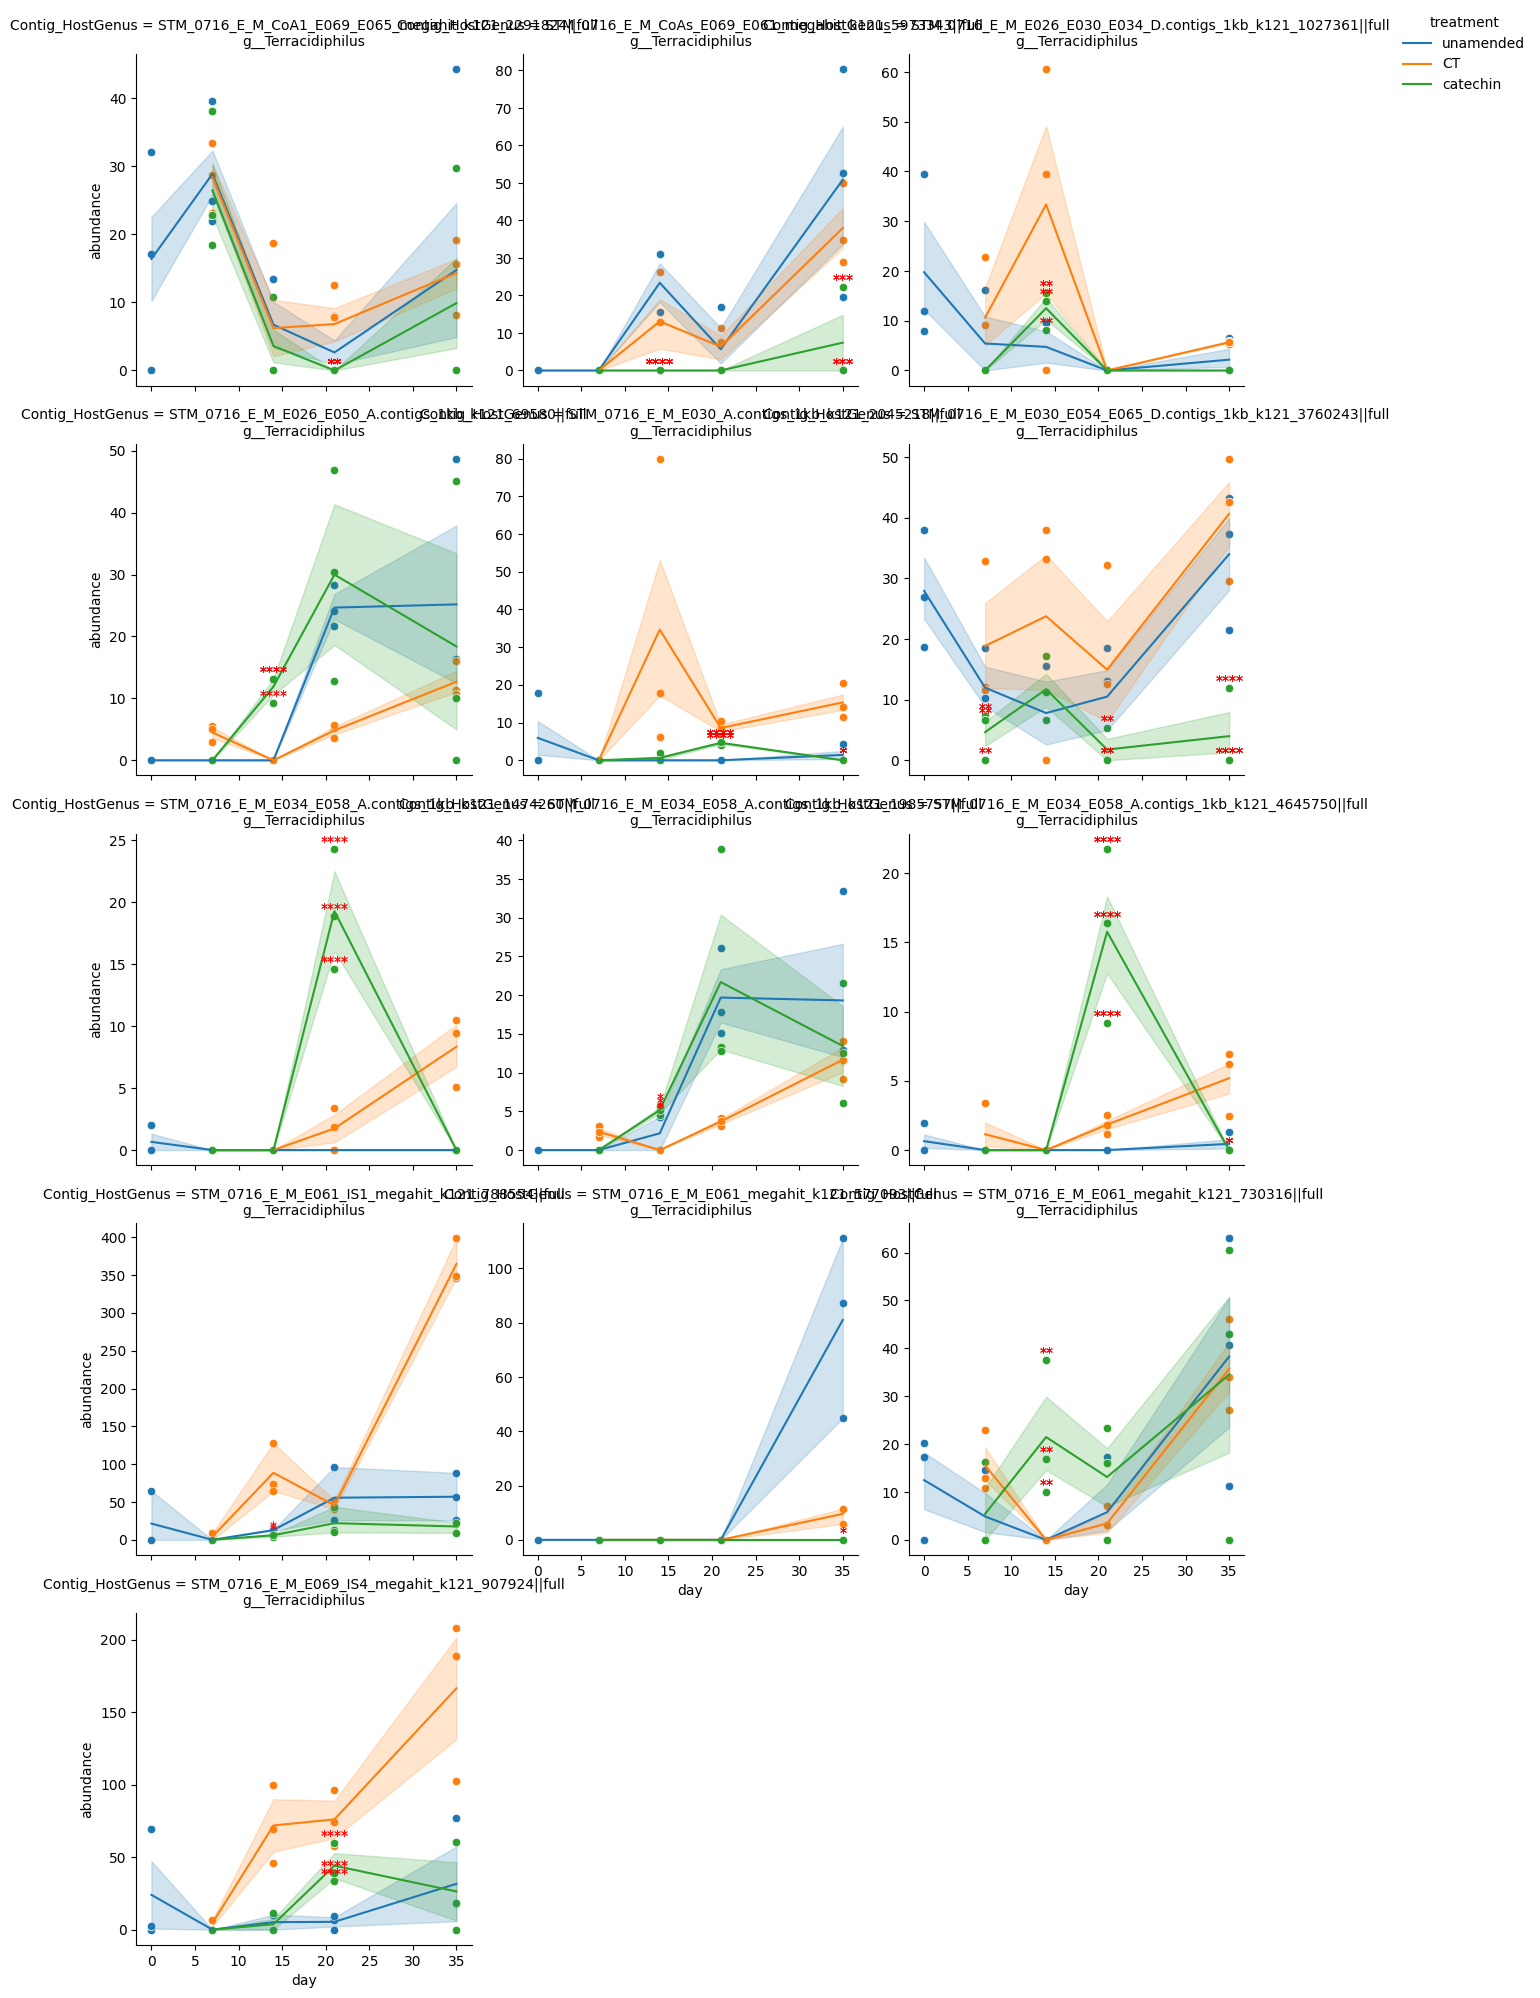

In [128]:
# Plot using Seaborn with col parameter
filtered_df = df.loc[(df['Contig_HostGenus'].isin(significant_results.Contig_HostGenus))
                    & (df['G'] == 'g__Terracidiphilus')]
g = sns.FacetGrid(filtered_df, col='Contig_HostGenus', hue='treatment', col_wrap=3, height=4, sharey=False)
g.map(sns.scatterplot, 'day', 'abundance', markers='o')

# Add a line through the average of the points
g.map(sns.lineplot, 'day', 'abundance', estimator='mean', linestyle='-')

# Add significance annotations
for ax in g.axes.flatten():
    contig_host_genus = ax.get_title().split('Contig_HostGenus = ')[1]
    for i, point in filtered_df[filtered_df['Contig_HostGenus'] == contig_host_genus].iterrows():
        if (point['Significance'] != '') & (point['treatment'] == 'catechin'):
            ax.text(point['day'], point['abundance'], point['Significance'], ha='center', va='bottom', color='red')

# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

All terracidiphiluis

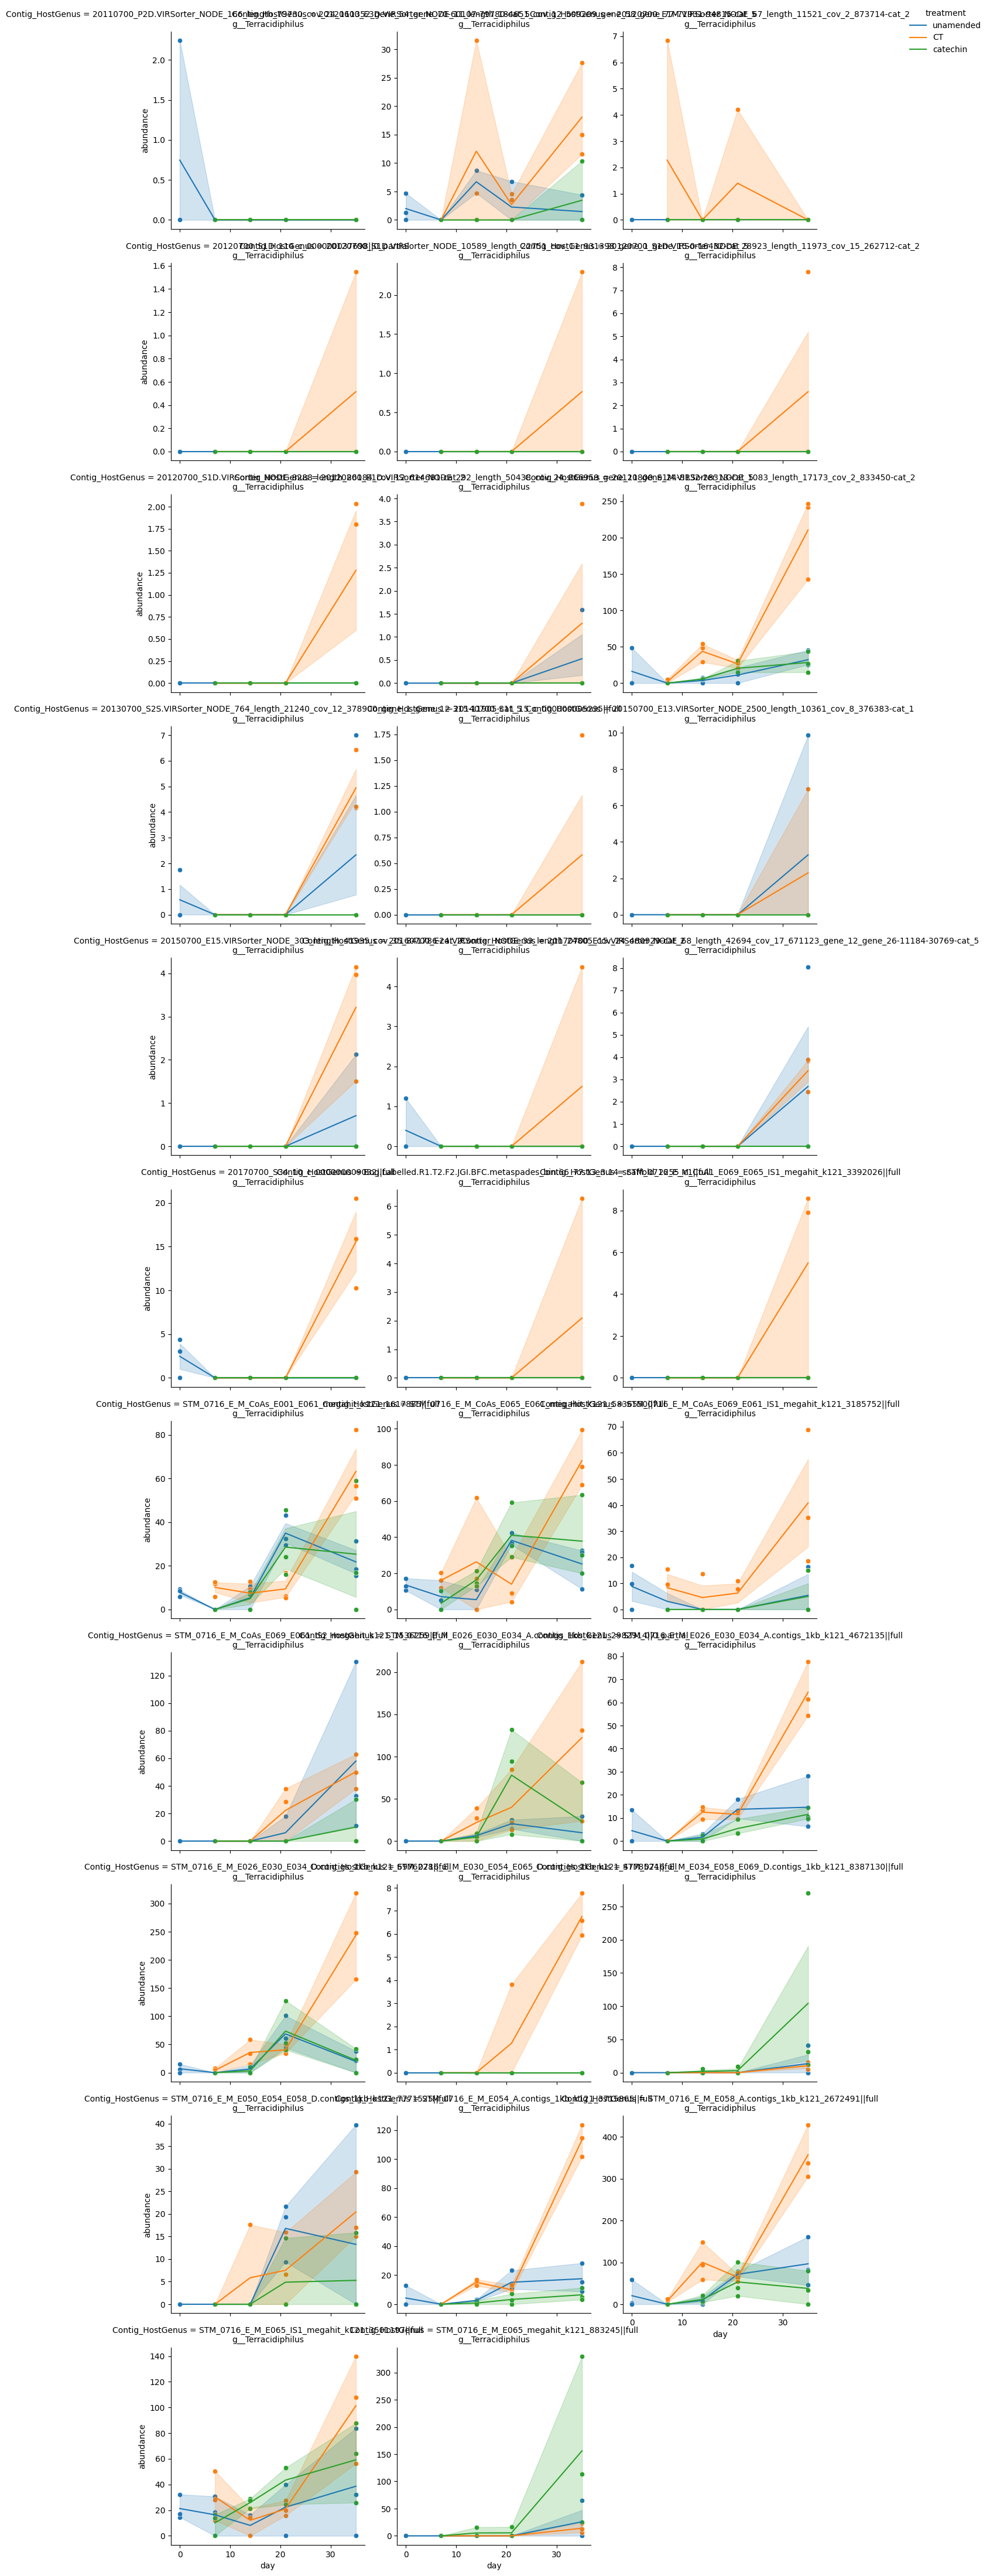

In [131]:
# Plot using Seaborn with col parameter
filtered_df = df.loc[~(df['Contig_HostGenus'].isin(significant_results.Contig_HostGenus))
                    & (df['G'] == 'g__Terracidiphilus')]
g = sns.FacetGrid(filtered_df, col='Contig_HostGenus', hue='treatment', col_wrap=3, height=4, sharey=False)
g.map(sns.scatterplot, 'day', 'abundance', markers='o')

# Add a line through the average of the points
g.map(sns.lineplot, 'day', 'abundance', estimator='mean', linestyle='-')

# Add significance annotations
for ax in g.axes.flatten():
    contig_host_genus = ax.get_title().split('Contig_HostGenus = ')[1]
    for i, point in filtered_df[filtered_df['Contig_HostGenus'] == contig_host_genus].iterrows():
        if (point['Significance'] != '') & (point['treatment'] == 'catechin'):
            ax.text(point['day'], point['abundance'], point['Significance'], ha='center', va='bottom', color='red')

# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

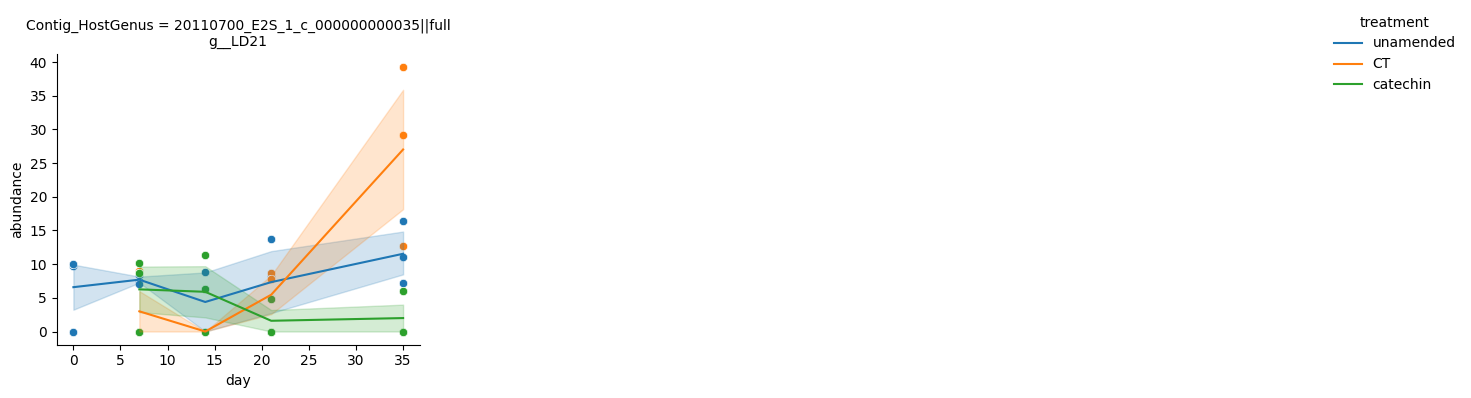

ValueError: Image size of 73743x139604 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2666.25x2800 with 40 Axes>

In [69]:
# Plot using Seaborn with col parameter
g = sns.FacetGrid(df.loc[df['Contig_HostGenus'].isin(list(filtered_results.Contig_HostGenus))],
                  col='Contig_HostGenus',
                  hue='treatment',
                  col_wrap=6,
                  height=4,
                  sharey=False)
g.map(sns.scatterplot, 'day', 'abundance', markers='o')

# Add a line through the average of the points
g.map(sns.lineplot, 'day', 'abundance', estimator='mean', linestyle='-')

# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 20})

plt.show()


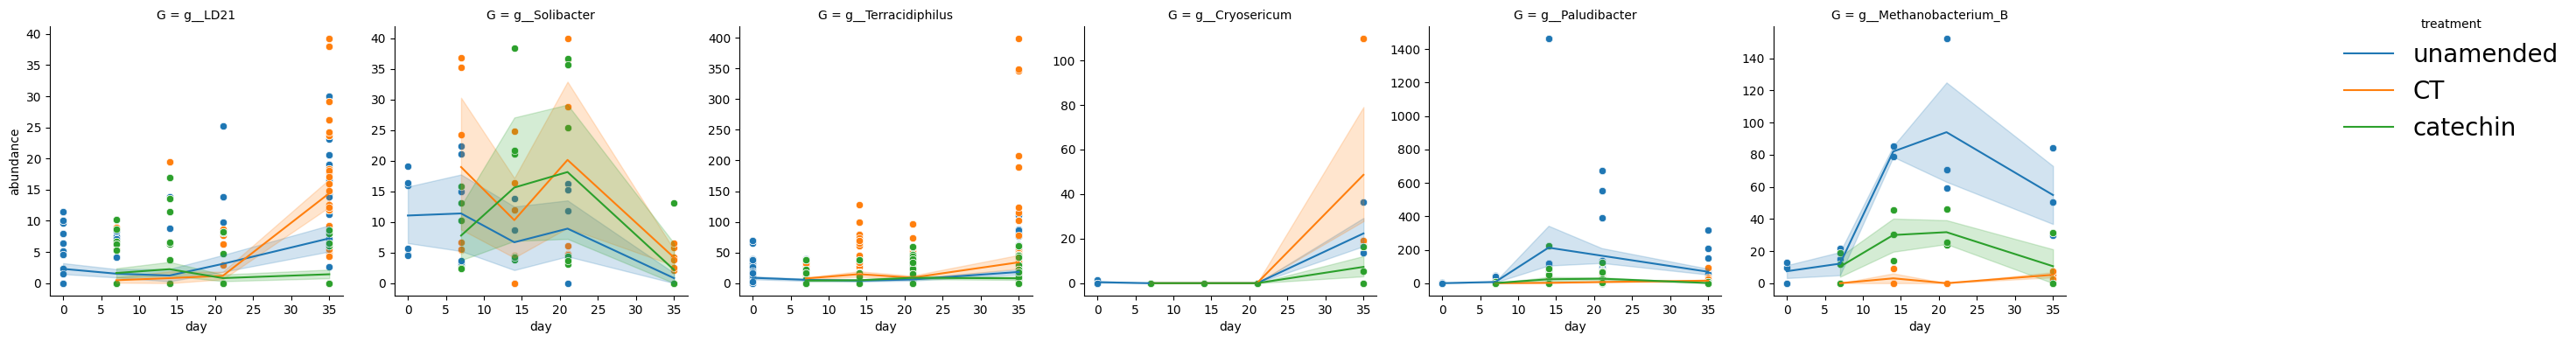

In [49]:
# Plot using Seaborn with col parameter
g = sns.FacetGrid(df.loc[df['Contig_HostGenus'].isin(list(filtered_results.Contig_HostGenus))],
                  col='G',
                  hue='treatment',
                  col_wrap=6,
                  height=4,
                  sharey=False)
g.map(sns.scatterplot, 'day', 'abundance', markers='o')

# Add a line through the average of the points
g.map(sns.lineplot, 'day', 'abundance', estimator='mean', linestyle='-')

# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 20})
plt.show()

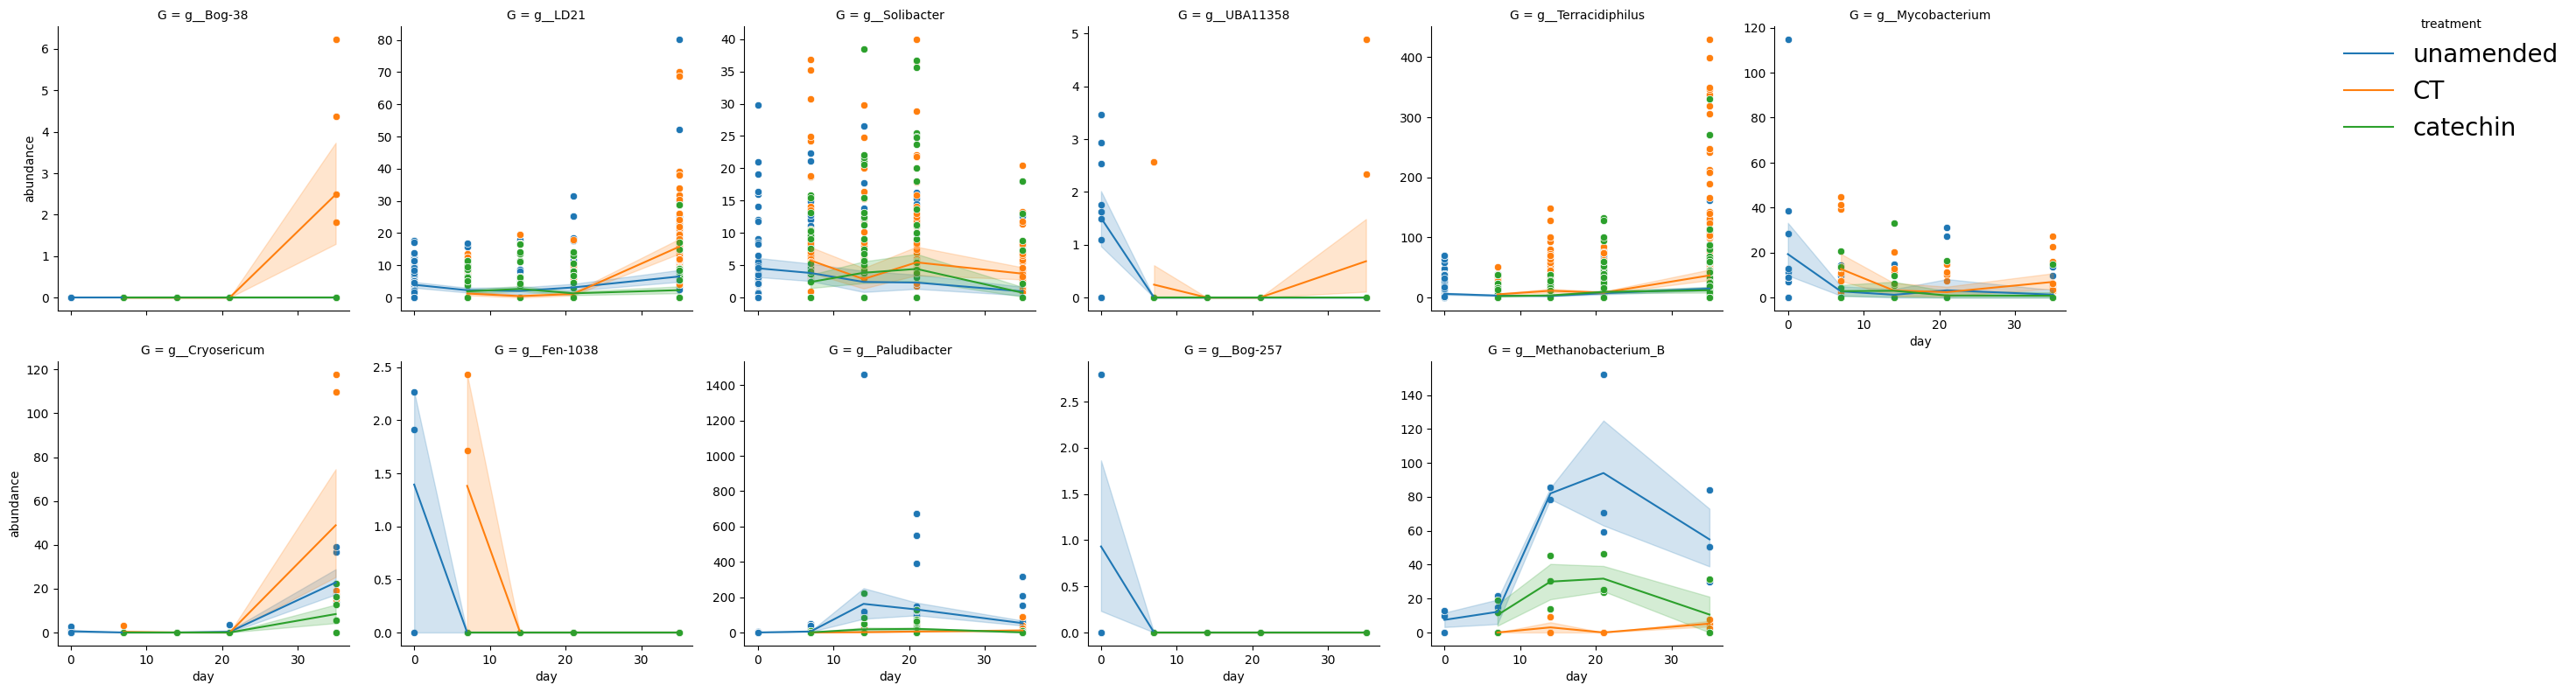

In [46]:
# Plot using Seaborn with col parameter
g = sns.FacetGrid(df,
                  col='G',
                  hue='treatment',
                  col_wrap=6,
                  height=4,
                  sharey=False)
g.map(sns.scatterplot, 'day', 'abundance', markers='o')

# Add a line through the average of the points
g.map(sns.lineplot, 'day', 'abundance', estimator='mean', linestyle='-')

# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 20})
plt.show()